In [1]:
# Kết nối Google Drive (nếu chạy trong Colab)
try:
    from google.colab import drive
    print("Kết nối Google Drive...")
    drive.mount('/content/drive')
except:
    print("Không thể kết nối Google Drive hoặc không chạy trong môi trường Colab.")

Kết nối Google Drive...
Mounted at /content/drive


In [2]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

# **Preprocess data**

In [3]:
def downsample_signal(signal_data, original_fs=300, target_fs=125):
    """
    Downsample tín hiệu từ tần số gốc xuống tần số mục tiêu

    Parameters:
    signal_data: array - Tín hiệu đầu vào
    original_fs: int - Tần số lấy mẫu ban đầu (Hz)
    target_fs: int - Tần số lấy mẫu mục tiêu (Hz)

    Returns:
    array - Tín hiệu đã được downsample
    """
    # Tính số mẫu mới
    new_length = int(len(signal_data) * target_fs / original_fs)

    # Sử dụng Fourier method để resample
    resampled_signal = signal.resample(signal_data, new_length)

    return resampled_signal

In [4]:
def load_mat_file(file_path):
    """Đọc dữ liệu từ file .mat"""
    try:
        with h5py.File(file_path, 'r') as mat_data:
            # In các khóa để debug
            print(f"Đang đọc file: {file_path}")
            print("Các khóa trong file:", list(mat_data.keys()))

            # Trích xuất tín hiệu
            try:
                ppg_signal = mat_data['signal']['pleth']['y'][0]
            except Exception as e:
                print(f"Lỗi trích xuất PPG: {e}")
                ppg_signal = None

            try:
                hr_ecg = mat_data['reference']['hr']['ecg']['y'][:]
            except Exception as e:
                print(f"Lỗi trích xuất HR: {e}")
                hr_ecg = None

            try:
                fs_pleth = mat_data['param']['samplingrate']['pleth'][0,0]
            except Exception as e:
                print(f"Lỗi trích xuất tần số lấy mẫu: {e}")
                fs_pleth = 125  # Giá trị mặc định

            # Kiểm tra dữ liệu
            if ppg_signal is None or hr_ecg is None:
                print(f"Dữ liệu không đầy đủ trong file {file_path}")
                return None

            # Downsample tín hiệu PPG từ 300Hz xuống 125Hz
            if fs_pleth == 300:
                ppg_signal = downsample_signal(ppg_signal, original_fs=300, target_fs=125)
                fs_pleth = 125
                print(f"Đã downsample tín hiệu từ 300Hz xuống 125Hz")

            return {
                'ppg_signal': ppg_signal,
                'hr_ecg': hr_ecg,
                'fs': fs_pleth,
                'file_name': os.path.basename(file_path)
            }
    except Exception as e:
        print(f"Lỗi khi mở file {file_path}: {e}")
        return None

In [5]:
def filter_signal(signal_data, fs=125, low_cutoff=0.5, high_cutoff=8.0):
    """Lọc tín hiệu với bộ lọc băng thông"""
    nyquist = fs / 2
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist
    b, a = signal.butter(4, [low, high], btype='band')
    filtered_signal = signal.filtfilt(b, a, signal_data)
    return filtered_signal

In [6]:
def collect_all_data(folder_path):
    """Bước 1: Tổng hợp tất cả các file .mat thành một tập dữ liệu"""
    all_data = []

    # Lặp qua các file .mat trong thư mục
    for filename in os.listdir(folder_path):
        if filename.endswith('.mat'):
            file_path = os.path.join(folder_path, filename)
            file_data = load_mat_file(file_path)

            if file_data:
                all_data.append(file_data)
                print(f"Đã đọc thành công file {filename}")
                print(f"Độ dài tín hiệu PPG: {len(file_data['ppg_signal'])}")
                print(f"Độ dài tín hiệu HR: {len(file_data['hr_ecg'])}")
                print(f"Tần số lấy mẫu: {file_data['fs']} Hz")
                print("-" * 50)

    print(f"Tổng số file đã đọc: {len(all_data)}")
    return all_data

In [7]:
def segment_all_signals(all_data, segment_length=750, overlap=0.5):
    """Phân đoạn tất cả tín hiệu mà không lọc theo HR"""
    all_ppg_segments = []
    all_ppg_normalized = []
    all_hr_raw = []

    for data in all_data:
        ppg_signal = data['ppg_signal']
        hr_values = data['hr_ecg'].flatten()
        fs = data['fs']

        # Lọc tín hiệu PPG
        filtered_ppg = filter_signal(ppg_signal, fs=fs)

        # Phân đoạn
        step = int(segment_length * (1 - overlap))
        num_segments = (len(filtered_ppg) - segment_length) // step + 1

        print(f"Xử lý file {data['file_name']}: {num_segments} đoạn")

        for j in range(num_segments):
            start = j * step
            end = start + segment_length

            if end <= len(filtered_ppg):
                # Lấy đoạn tín hiệu
                ppg_seg = filtered_ppg[start:end]

                # Tính vị trí tương ứng trong mảng HR
                hr_start_idx = int(start / len(ppg_signal) * len(hr_values))
                hr_end_idx = int(end / len(ppg_signal) * len(hr_values))

                # Đảm bảo chỉ số không vượt quá giới hạn
                hr_start_idx = min(hr_start_idx, len(hr_values) - 1)
                hr_end_idx = min(hr_end_idx, len(hr_values))

                # Lấy đoạn HR tương ứng
                segment_hr_values = hr_values[hr_start_idx:hr_end_idx]

                # Nếu không có giá trị HR nào, sử dụng giá trị gần nhất
                if len(segment_hr_values) == 0:
                    segment_hr = hr_values[hr_start_idx]
                else:
                    # Tính giá trị trung bình của HR trong đoạn
                    segment_hr = np.mean(segment_hr_values)

                # Chuẩn hóa PPG về [-1, 1]
                scaler = MinMaxScaler(feature_range=(-1, 1))
                ppg_seg_normalized = scaler.fit_transform(ppg_seg.reshape(-1, 1)).flatten()

                all_ppg_segments.append(ppg_seg)
                all_ppg_normalized.append(ppg_seg_normalized)
                all_hr_raw.append(segment_hr)

    # Chuyển về numpy array
    all_ppg_segments = np.array(all_ppg_segments)
    all_ppg_normalized = np.array(all_ppg_normalized)
    all_hr_raw = np.array(all_hr_raw)

    # Vẽ phân phối HR của tất cả các đoạn
    plt.figure(figsize=(15, 6))
    plt.hist(all_hr_raw, bins=30, alpha=0.7, color='blue')
    plt.title("Phân phối HR của tất cả các đoạn")
    plt.xlabel("HR (BPM)")
    plt.ylabel("Số lượng")
    plt.grid(True)
    plt.show()

    # Tính thống kê HR
    hr_mean = np.mean(all_hr_raw)
    hr_std = np.std(all_hr_raw)
    hr_min = np.min(all_hr_raw)
    hr_max = np.max(all_hr_raw)

    print(f"Thống kê HR:")
    print(f"Mean: {hr_mean:.2f} BPM")
    print(f"Std: {hr_std:.2f} BPM")
    print(f"Min: {hr_min:.2f} BPM")
    print(f"Max: {hr_max:.2f} BPM")

    print(f"Tổng số đoạn: {len(all_ppg_segments)}")
    print(f"Độ dài mỗi segment: {segment_length} điểm (~{segment_length/125:.2f} giây ở 125Hz)")

    # Vẽ một số đoạn PPG
    plt.figure(figsize=(15, 10))

    # Vẽ 5 đoạn PPG đầu tiên
    for i in range(min(5, len(all_ppg_segments))):
        plt.subplot(5, 1, i+1)
        plt.plot(all_ppg_segments[i])
        plt.title(f"Đoạn PPG {i+1} - HR trung bình: {all_hr_raw[i]:.2f} BPM")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    return all_ppg_segments, all_ppg_normalized, all_hr_raw

In [8]:
def prepare_data_loaders(ppg_segments, ppg_normalized, hr_raw):
    """Chuẩn bị DataLoader cho huấn luyện"""
    # Chia train/test
    train_size = int(0.8 * len(ppg_segments))
    indices = np.random.permutation(len(ppg_segments))
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    X_train = ppg_segments[train_indices]
    X_test = ppg_segments[test_indices]

    X_train_norm = ppg_normalized[train_indices]
    X_test_norm = ppg_normalized[test_indices]

    hr_raw_train = hr_raw[train_indices]
    hr_raw_test = hr_raw[test_indices]

    # Chuẩn bị DataLoader
    train_dataset = TensorDataset(
        torch.FloatTensor(X_train_norm),
        torch.FloatTensor(hr_raw_train.reshape(-1, 1))
    )
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    test_dataset = TensorDataset(
        torch.FloatTensor(X_test_norm),
        torch.FloatTensor(hr_raw_test.reshape(-1, 1))
    )
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Xuất thông tin
    print("\nThông tin xử lý:")
    print(f"Tổng số đoạn PPG: {len(ppg_segments)}")
    print(f"Kích thước tập train: {X_train.shape}")
    print(f"Kích thước tập test: {X_test.shape}")

    return train_loader, test_loader, X_train, X_test, X_train_norm, X_test_norm, hr_raw_train, hr_raw_test

In [9]:
def process_mat_folder(folder_path):
    """Hàm chính để xử lý toàn bộ thư mục"""
    # Bước 1: Tổng hợp tất cả các file
    print("Bước 1: Đang tổng hợp dữ liệu từ tất cả các file...")
    all_data = collect_all_data(folder_path)

    if not all_data:
        raise ValueError("Không có dữ liệu nào được đọc từ thư mục")

    # Bước 2: Phân đoạn tất cả tín hiệu
    print("\nBước 2: Đang phân đoạn tất cả tín hiệu...")
    all_ppg_segments, all_ppg_normalized, all_hr_raw = segment_all_signals(all_data)

    # Chuẩn bị DataLoader
    print("\nĐang chuẩn bị DataLoader cho huấn luyện...")
    result = prepare_data_loaders(all_ppg_segments, all_ppg_normalized, all_hr_raw)

    return result

Bước 1: Đang tổng hợp dữ liệu từ tất cả các file...
Đang đọc file: /content/drive/MyDrive/cuoiky/capnobase/0103_8min.mat
Các khóa trong file: ['#refs#', 'SFresults', 'labels', 'meta', 'param', 'reference', 'signal']
Đã downsample tín hiệu từ 300Hz xuống 125Hz
Đã đọc thành công file 0103_8min.mat
Độ dài tín hiệu PPG: 60000
Độ dài tín hiệu HR: 825
Tần số lấy mẫu: 125 Hz
--------------------------------------------------
Đang đọc file: /content/drive/MyDrive/cuoiky/capnobase/0030_8min.mat
Các khóa trong file: ['#refs#', 'SFresults', 'labels', 'meta', 'param', 'reference', 'signal']
Đã downsample tín hiệu từ 300Hz xuống 125Hz
Đã đọc thành công file 0030_8min.mat
Độ dài tín hiệu PPG: 60000
Độ dài tín hiệu HR: 867
Tần số lấy mẫu: 125 Hz
--------------------------------------------------
Đang đọc file: /content/drive/MyDrive/cuoiky/capnobase/0023_8min.mat
Các khóa trong file: ['#refs#', 'SFresults', 'labels', 'meta', 'param', 'reference', 'signal']
Đã downsample tín hiệu từ 300Hz xuống 125Hz


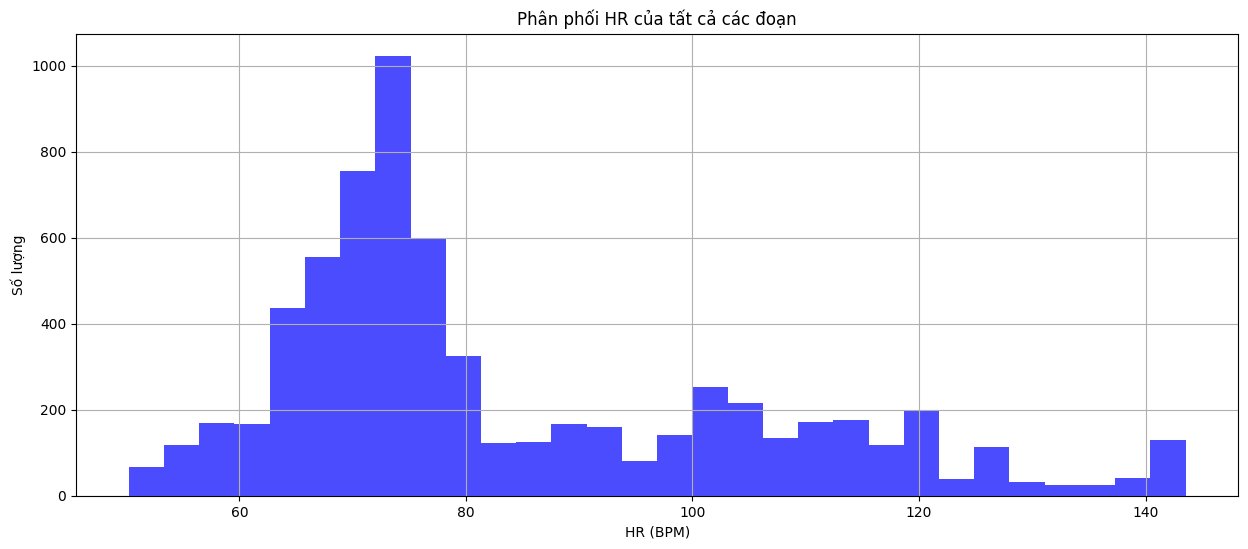

Thống kê HR:
Mean: 83.95 BPM
Std: 21.07 BPM
Min: 50.23 BPM
Max: 143.53 BPM
Tổng số đoạn: 6678
Độ dài mỗi segment: 750 điểm (~6.00 giây ở 125Hz)


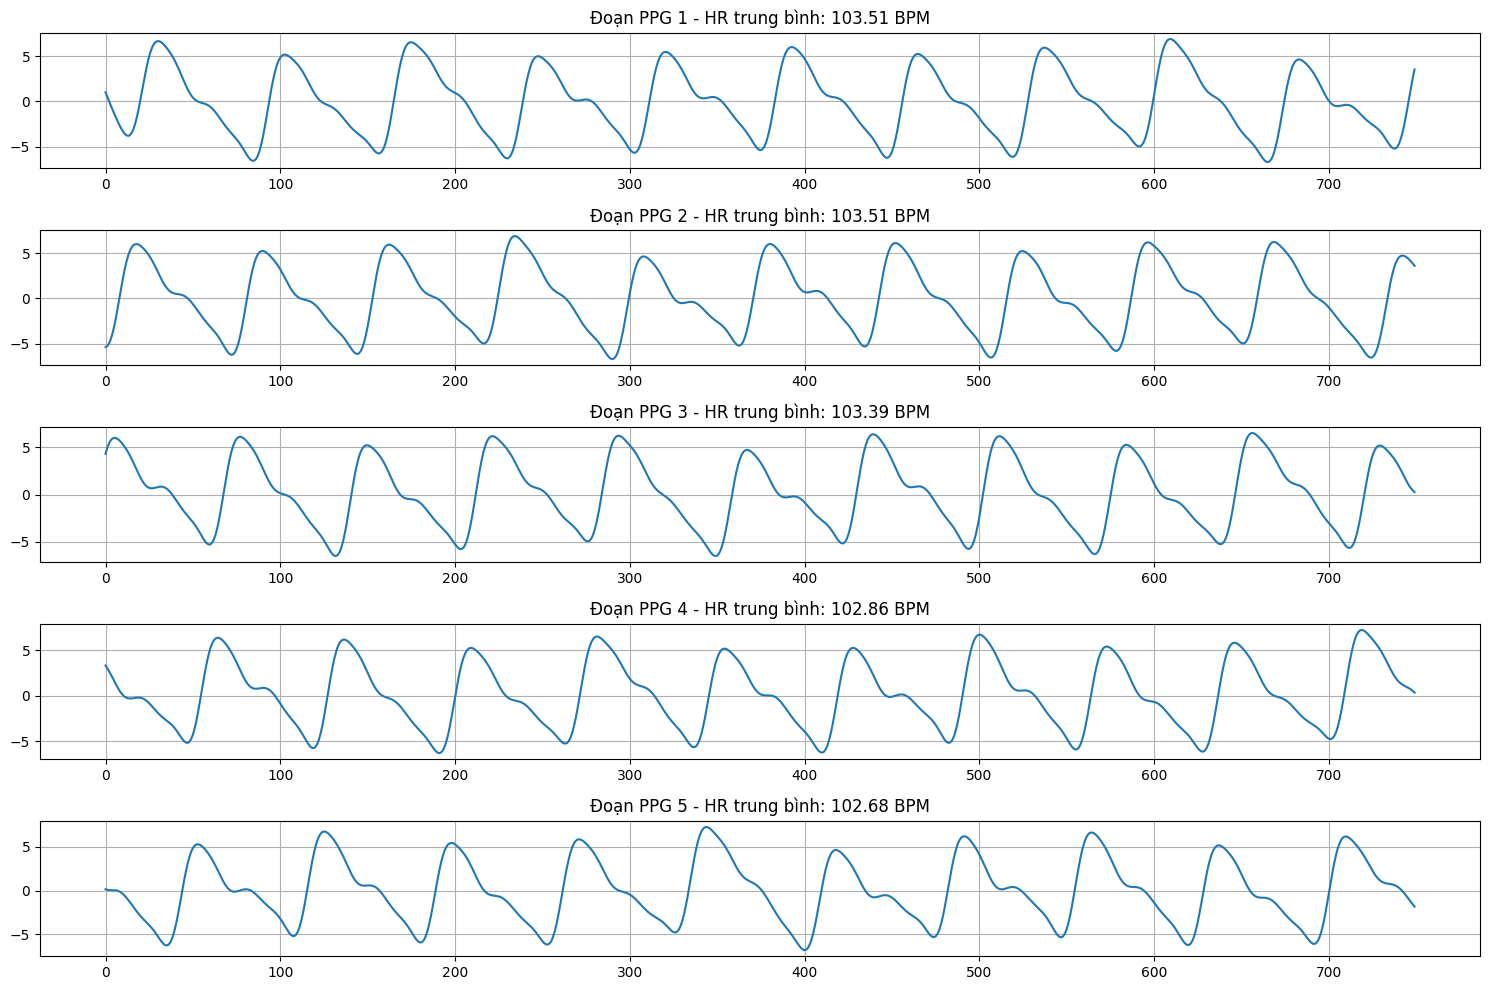


Đang chuẩn bị DataLoader cho huấn luyện...

Thông tin xử lý:
Tổng số đoạn PPG: 6678
Kích thước tập train: (5342, 750)
Kích thước tập test: (1336, 750)
Đã lưu dữ liệu vào file 'processed_capno_data.mat'

Shape của các dữ liệu:
X_train shape: (5342, 750)
X_test shape: (1336, 750)
X_train_norm shape: (5342, 750)
X_test_norm shape: (1336, 750)
hr_raw_train shape: (5342,)
hr_raw_test shape: (1336,)


In [10]:
# Sử dụng
folder_path = '/content/drive/MyDrive/cuoiky/capnobase'
result = process_mat_folder(folder_path)
train_loader, test_loader, X_train, X_test, X_train_norm, X_test_norm, hr_raw_train, hr_raw_test = result

# Lưu dữ liệu đã xử lý vào file .mat
import scipy.io as sio

# Tạo dictionary chứa tất cả dữ liệu cần lưu
data_to_save = {
    'X_train_norm': X_train_norm,
    'X_test_norm': X_test_norm,
    'hr_raw_train': hr_raw_train,
    'hr_raw_test': hr_raw_test,
    'X_total_norm': np.concatenate((X_train_norm, X_test_norm), axis=0),
    'hr_raw_total': np.concatenate((hr_raw_train, hr_raw_test), axis=0)
}

# Lưu vào file .mat
sio.savemat('processed_capno_data.mat', data_to_save)
print("Đã lưu dữ liệu vào file 'processed_capno_data.mat'")

# In ra shape của các dữ liệu
print("\nShape của các dữ liệu:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_train_norm shape: {X_train_norm.shape}")
print(f"X_test_norm shape: {X_test_norm.shape}")
print(f"hr_raw_train shape: {hr_raw_train.shape}")
print(f"hr_raw_test shape: {hr_raw_test.shape}")


Kiểm tra một số segment PPG và HR tương ứng:

Mẫu từ tập train:
Segment 0:
  - Độ dài segment PPG: 750
  - Giá trị HR (BPM): 91.12


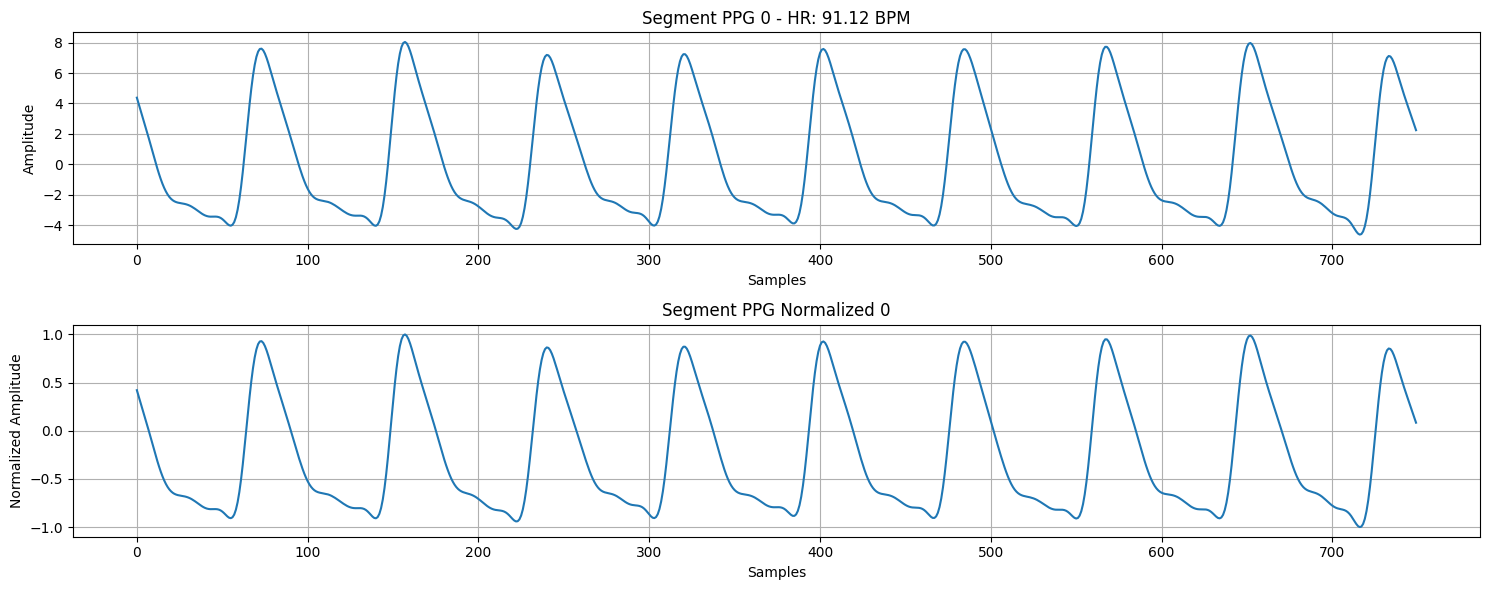

Segment 1:
  - Độ dài segment PPG: 750
  - Giá trị HR (BPM): 66.43


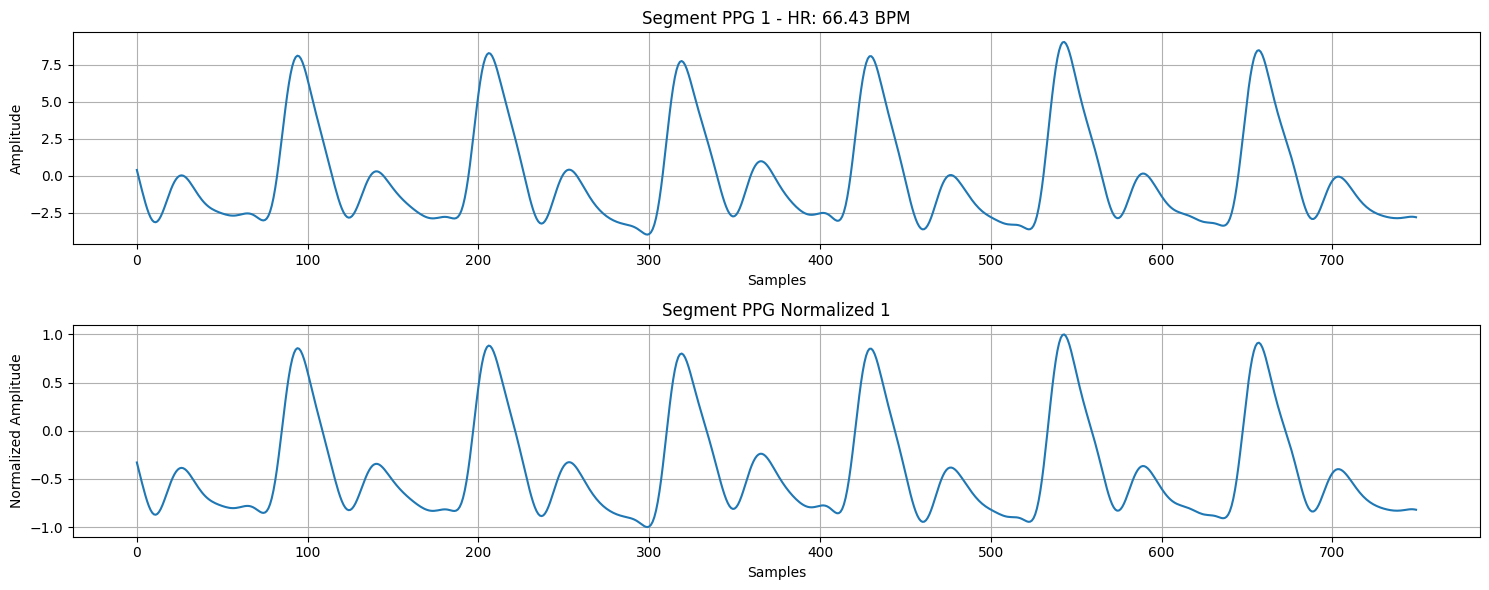

Segment 2:
  - Độ dài segment PPG: 750
  - Giá trị HR (BPM): 65.93


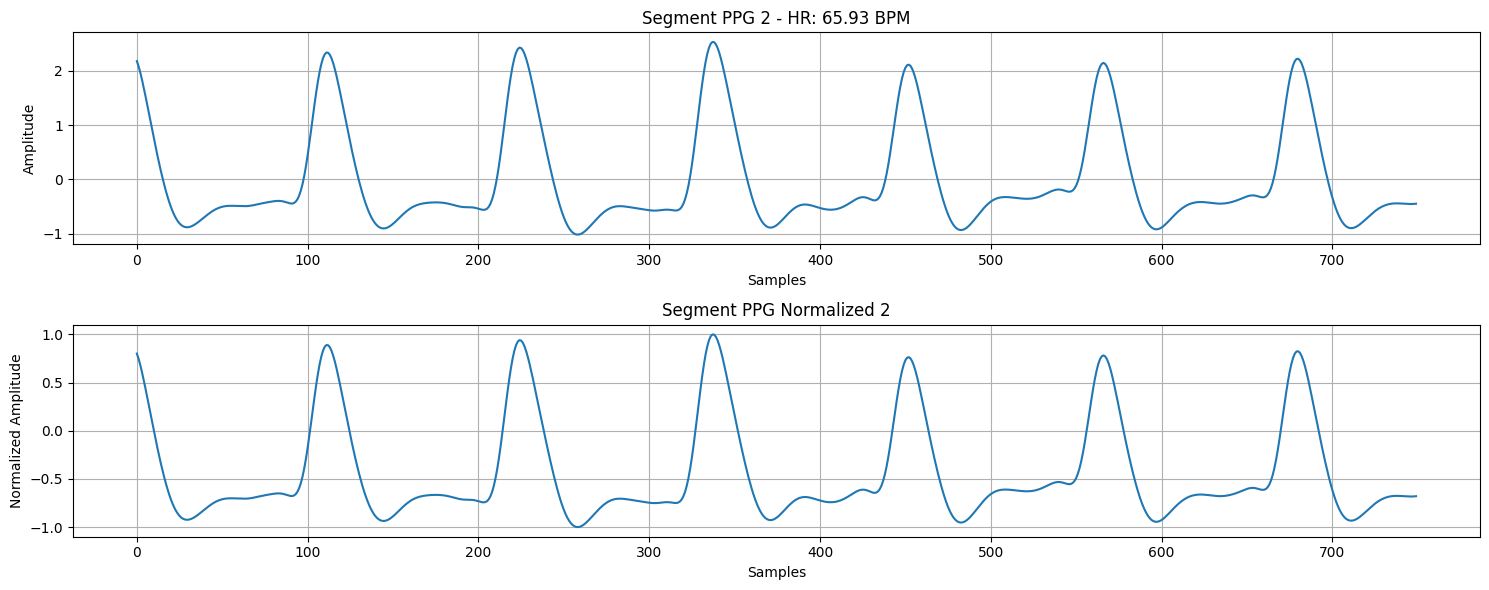

In [11]:
# Kiểm tra một vài segment PPG và giá trị HR tương ứng
print("\nKiểm tra một số segment PPG và HR tương ứng:")

# Lấy một vài mẫu ngẫu nhiên từ tập train
train_sample_indices = np.random.choice(len(X_train), size=3, replace=False)
print("\nMẫu từ tập train:")
for i, idx in enumerate(train_sample_indices):
    ppg_segment = X_train[idx]
    ppg_norm = X_train_norm[idx]
    hr_raw_value = hr_raw_train[idx]

    print(f"Segment {i}:")
    print(f"  - Độ dài segment PPG: {len(ppg_segment)}")
    print(f"  - Giá trị HR (BPM): {hr_raw_value:.2f}")

    # Vẽ segment PPG
    plt.figure(figsize=(15, 6))
    plt.subplot(2, 1, 1)
    plt.plot(ppg_segment)
    plt.title(f"Segment PPG {i} - HR: {hr_raw_value:.2f} BPM")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Vẽ segment PPG normalized
    plt.subplot(2, 1, 2)
    plt.plot(ppg_norm)
    plt.title(f"Segment PPG Normalized {i}")
    plt.xlabel("Samples")
    plt.ylabel("Normalized Amplitude")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Mẫu từ tập test:
Segment 0:
  - Độ dài segment PPG: 750
  - Giá trị HR (BPM): 78.01


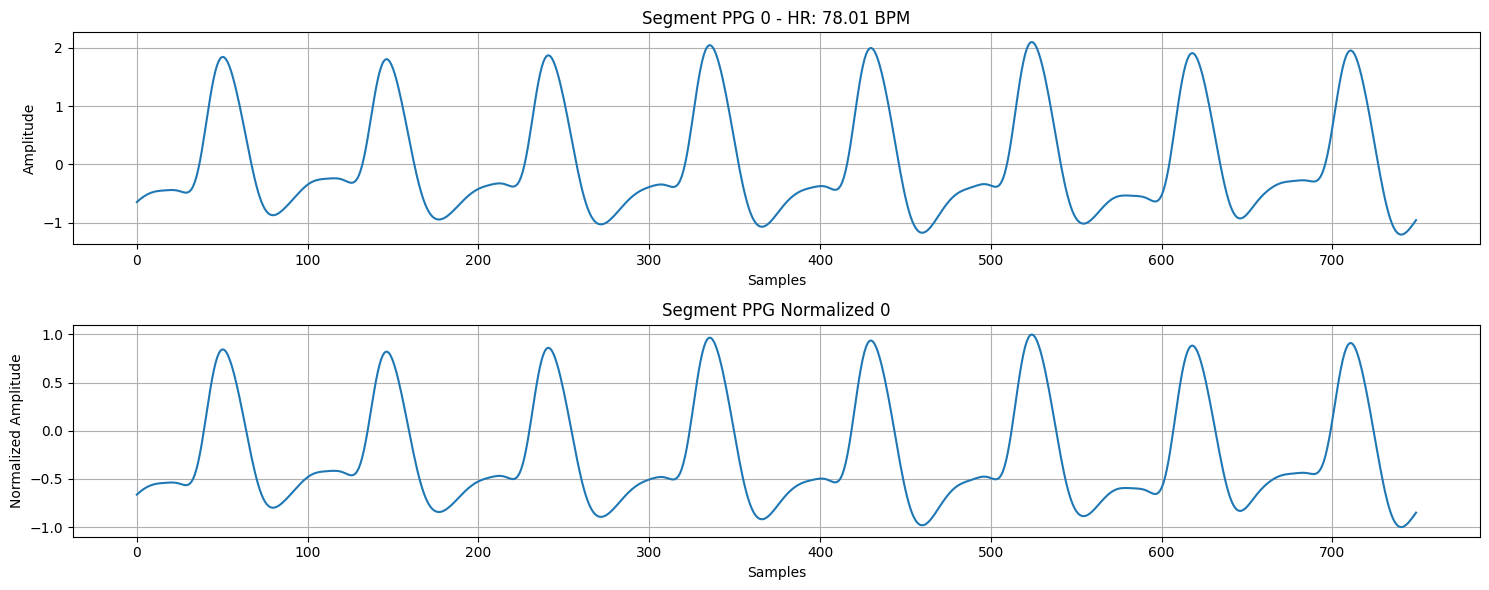

Segment 1:
  - Độ dài segment PPG: 750
  - Giá trị HR (BPM): 73.11


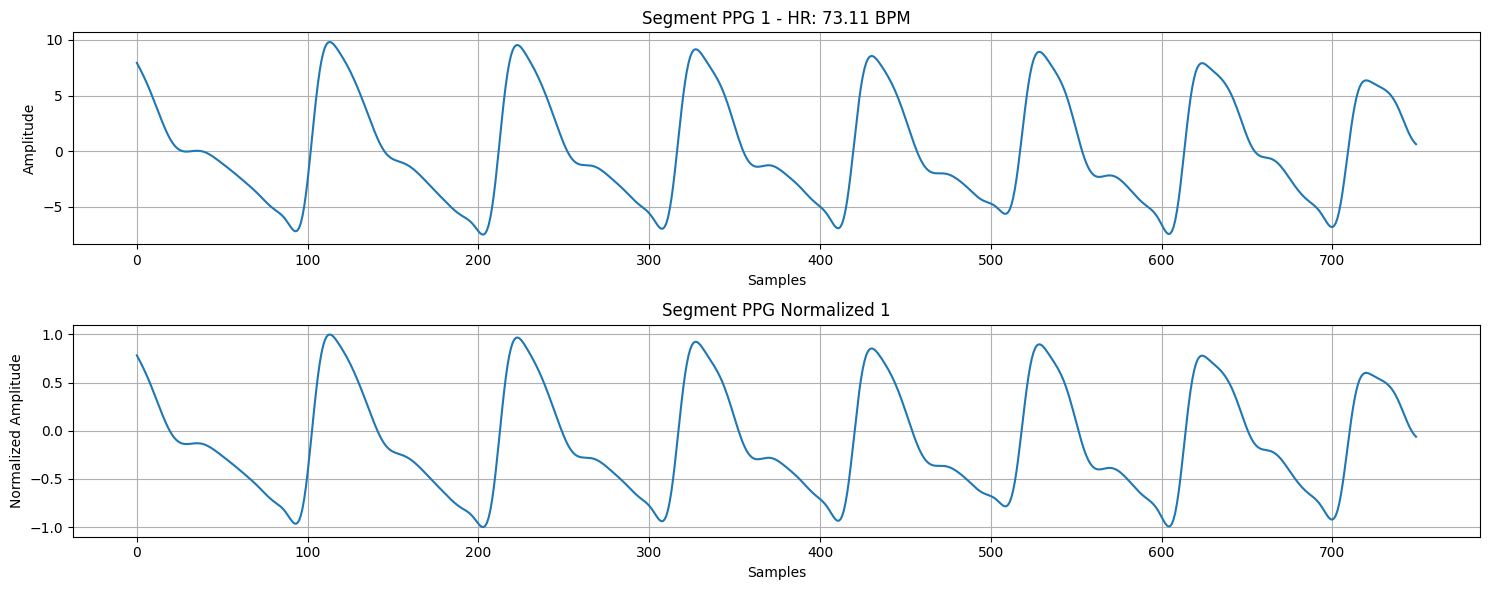

Segment 2:
  - Độ dài segment PPG: 750
  - Giá trị HR (BPM): 73.00


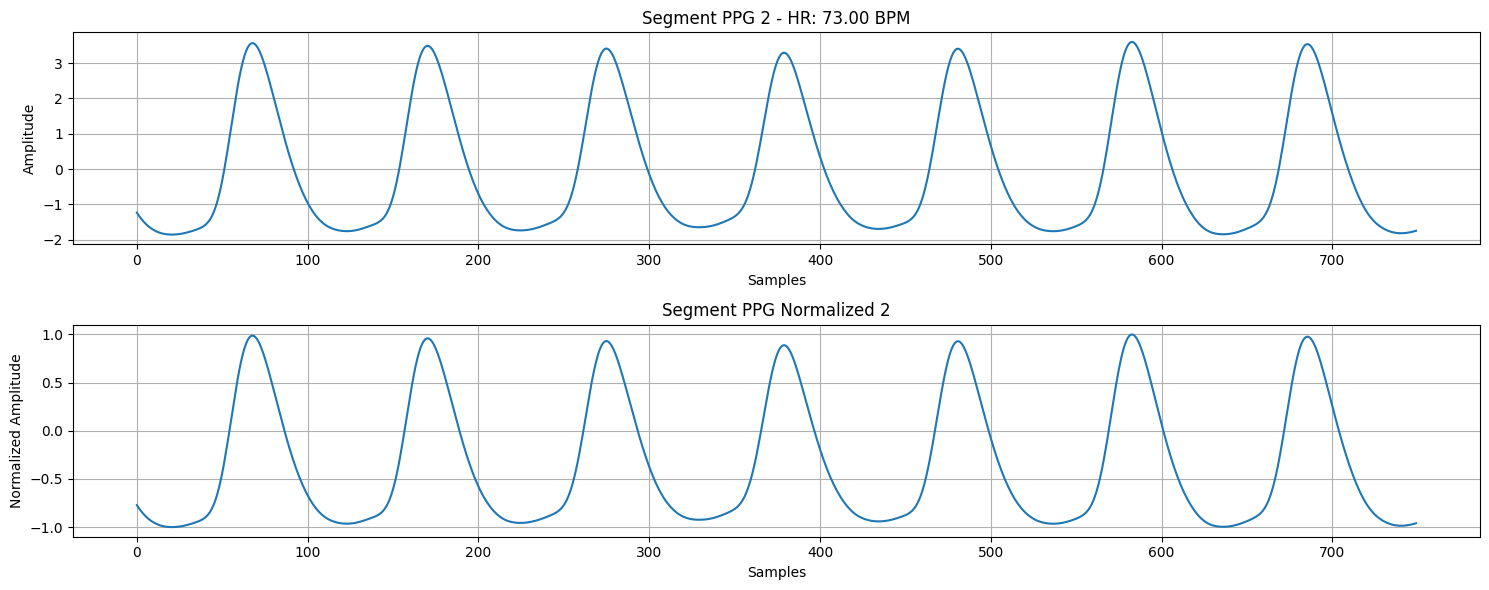

In [12]:
# Lấy một vài mẫu ngẫu nhiên từ tập test
test_sample_indices = np.random.choice(len(X_test), size=3, replace=False)
print("\nMẫu từ tập test:")
for i, idx in enumerate(test_sample_indices):
    ppg_segment = X_test[idx]
    ppg_norm = X_test_norm[idx]
    hr_raw_value = hr_raw_test[idx]

    print(f"Segment {i}:")
    print(f"  - Độ dài segment PPG: {len(ppg_segment)}")
    print(f"  - Giá trị HR (BPM): {hr_raw_value:.2f}")

    # Vẽ segment PPG
    plt.figure(figsize=(15, 6))
    plt.subplot(2, 1, 1)
    plt.plot(ppg_segment)
    plt.title(f"Segment PPG {i} - HR: {hr_raw_value:.2f} BPM")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.grid(True)

    # Vẽ segment PPG normalized
    plt.subplot(2, 1, 2)
    plt.plot(ppg_norm)
    plt.title(f"Segment PPG Normalized {i}")
    plt.xlabel("Samples")
    plt.ylabel("Normalized Amplitude")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

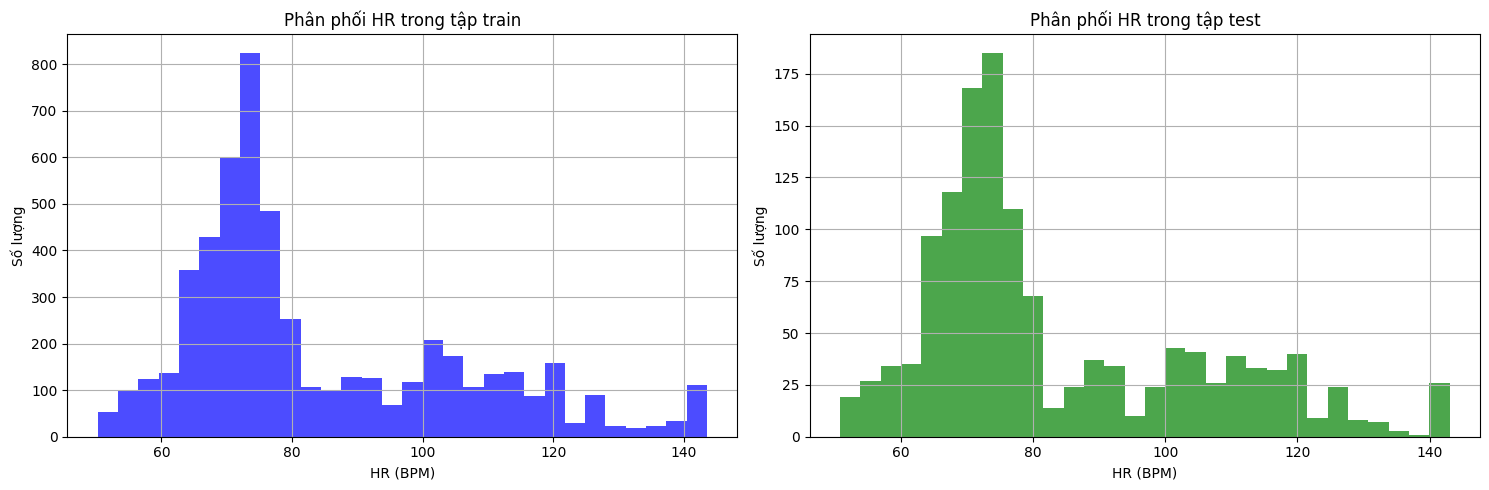

In [13]:
# Kiểm tra phân phối HR trong tập train và test
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(hr_raw_train, bins=30, alpha=0.7, color='blue')
plt.title("Phân phối HR trong tập train")
plt.xlabel("HR (BPM)")
plt.ylabel("Số lượng")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(hr_raw_test, bins=30, alpha=0.7, color='green')
plt.title("Phân phối HR trong tập test")
plt.xlabel("HR (BPM)")
plt.ylabel("Số lượng")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Load dữ liệu từ file .mat đã lưu
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [15]:
# Load dữ liệu từ file .mat
data = sio.loadmat('processed_capno_data.mat')

# Trích xuất các biến từ file
X_train_norm = data['X_train_norm']
X_test_norm = data['X_test_norm']
hr_raw_train = data['hr_raw_train']
hr_raw_test = data['hr_raw_test']
X_total_norm = data['X_total_norm']
hr_raw_total = data['hr_raw_total']

print(f"Đã load dữ liệu từ file 'processed_capno_data.mat'")
print(f"Kích thước X_train_norm: {X_train_norm.shape}")
print(f"Kích thước X_test_norm: {X_test_norm.shape}")
print(f"Kích thước hr_raw_train: {hr_raw_train.shape}")
print(f"Kích thước hr_raw_test: {hr_raw_test.shape}")

# Chuyển đổi dữ liệu sang tensor PyTorch
X_train_tensor = torch.FloatTensor(X_train_norm)
X_test_tensor = torch.FloatTensor(X_test_norm)
hr_train_tensor = torch.FloatTensor(hr_raw_train)
hr_test_tensor = torch.FloatTensor(hr_raw_test)

# Kiểm tra và đảm bảo kích thước phù hợp
print(f"Kích thước X_train_tensor: {X_train_tensor.shape}")
print(f"Kích thước hr_train_tensor: {hr_train_tensor.shape}")
print(f"Kích thước X_test_tensor: {X_test_tensor.shape}")
print(f"Kích thước hr_test_tensor: {hr_test_tensor.shape}")

Đã load dữ liệu từ file 'processed_capno_data.mat'
Kích thước X_train_norm: (5342, 750)
Kích thước X_test_norm: (1336, 750)
Kích thước hr_raw_train: (1, 5342)
Kích thước hr_raw_test: (1, 1336)
Kích thước X_train_tensor: torch.Size([5342, 750])
Kích thước hr_train_tensor: torch.Size([1, 5342])
Kích thước X_test_tensor: torch.Size([1336, 750])
Kích thước hr_test_tensor: torch.Size([1, 1336])


In [16]:
# Đảm bảo hr_train_tensor và hr_test_tensor có cùng số mẫu với X_train_tensor và X_test_tensor
if hr_train_tensor.shape[0] != X_train_tensor.shape[0]:
    # Cắt bớt hoặc điều chỉnh kích thước để khớp nhau
    min_size = min(hr_train_tensor.shape[0], X_train_tensor.shape[0])
    X_train_tensor = X_train_tensor[:min_size]
    hr_train_tensor = hr_train_tensor[:min_size]
    print(f"Đã điều chỉnh kích thước train data: X={X_train_tensor.shape}, hr={hr_train_tensor.shape}")

if hr_test_tensor.shape[0] != X_test_tensor.shape[0]:
    # Cắt bớt hoặc điều chỉnh kích thước để khớp nhau
    min_size = min(hr_test_tensor.shape[0], X_test_tensor.shape[0])
    X_test_tensor = X_test_tensor[:min_size]
    hr_test_tensor = hr_test_tensor[:min_size]
    print(f"Đã điều chỉnh kích thước test data: X={X_test_tensor.shape}, hr={hr_test_tensor.shape}")

Đã điều chỉnh kích thước train data: X=torch.Size([1, 750]), hr=torch.Size([1, 5342])
Đã điều chỉnh kích thước test data: X=torch.Size([1, 750]), hr=torch.Size([1, 1336])


In [17]:
# Tạo dataset và dataloader
train_dataset = TensorDataset(X_train_tensor, hr_train_tensor)
test_dataset = TensorDataset(X_test_tensor, hr_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Kiểm tra device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng device: {device}")

Sử dụng device: cuda


# **MODEL**

In [18]:
# Kiểm tra và sửa lỗi kích thước mô hình
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat  # Thêm import loadmat từ scipy.io

# Load dữ liệu từ file .mat
print("Đang load dữ liệu từ file processed_capno_data.mat...")
loaded_data = loadmat('processed_capno_data.mat')


Đang load dữ liệu từ file processed_capno_data.mat...



Shape của dữ liệu đã load:
X_train_loaded shape: (5342, 750)
hr_raw_train_loaded shape: (5342,)
X_test_loaded shape: (1336, 750)
hr_raw_test_loaded shape: (1336,)
X_total_loaded shape: (6678, 750)
hr_raw_total_loaded shape: (6678,)

Thống kê HR raw total:
Min: 50.23, Max: 143.53
Mean: 83.95, Std: 21.07
Mean ± Std: 83.95 ± 21.07


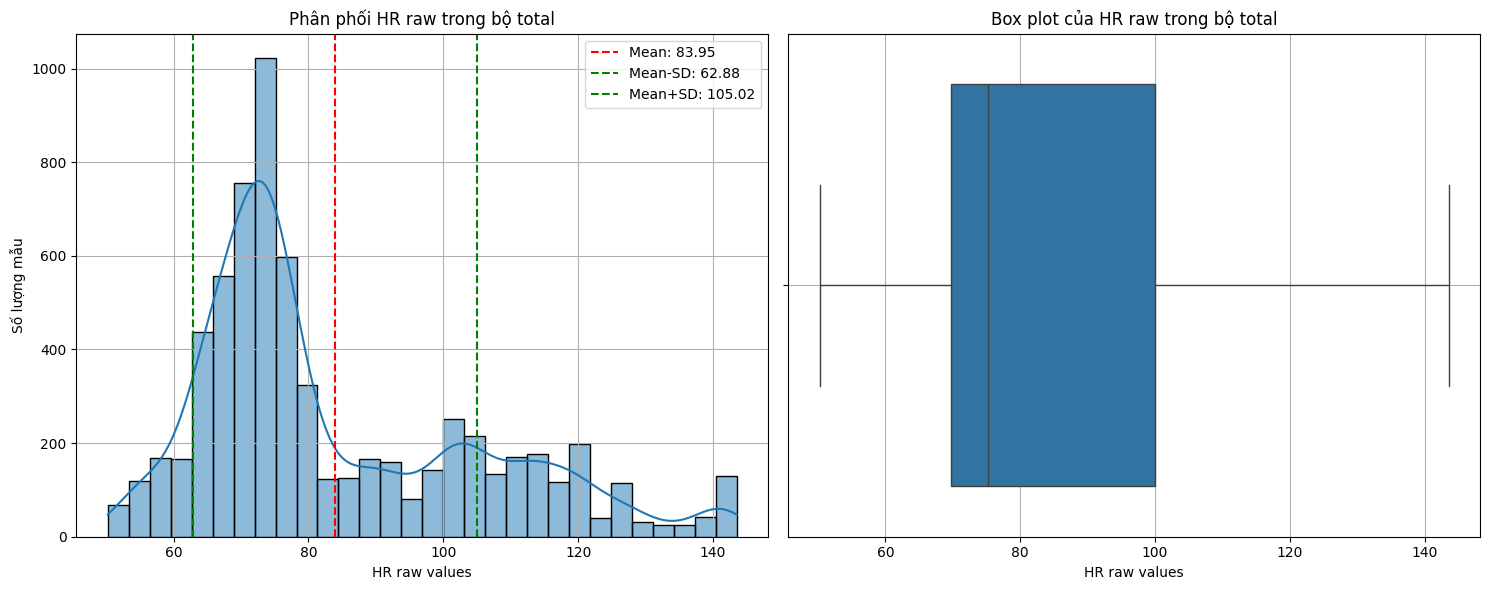

In [19]:
# Trích xuất dữ liệu
X_train_loaded = loaded_data['X_train_norm']
X_test_loaded = loaded_data['X_test_norm']
hr_raw_train_loaded = loaded_data['hr_raw_train'].flatten()  # Flatten để chuyển từ (1, n) thành (n,)
hr_raw_test_loaded = loaded_data['hr_raw_test'].flatten()    # Flatten để chuyển từ (1, n) thành (n,)
X_total_loaded = loaded_data['X_total_norm']
hr_raw_total_loaded = loaded_data['hr_raw_total'].flatten()  # Flatten để chuyển từ (1, n) thành (n,)

# Kiểm tra kích thước dữ liệu đã load
print("\nShape của dữ liệu đã load:")
print(f"X_train_loaded shape: {X_train_loaded.shape}")
print(f"hr_raw_train_loaded shape: {hr_raw_train_loaded.shape}")
print(f"X_test_loaded shape: {X_test_loaded.shape}")
print(f"hr_raw_test_loaded shape: {hr_raw_test_loaded.shape}")
print(f"X_total_loaded shape: {X_total_loaded.shape}")
print(f"hr_raw_total_loaded shape: {hr_raw_total_loaded.shape}")

# Tính toán thống kê cho hr_raw_total_loaded
hr_raw_total_min = np.min(hr_raw_total_loaded)
hr_raw_total_max = np.max(hr_raw_total_loaded)
hr_raw_total_mean = np.mean(hr_raw_total_loaded)
hr_raw_total_std = np.std(hr_raw_total_loaded)

# In thống kê
print("\nThống kê HR raw total:")
print(f"Min: {hr_raw_total_min:.2f}, Max: {hr_raw_total_max:.2f}")
print(f"Mean: {hr_raw_total_mean:.2f}, Std: {hr_raw_total_std:.2f}")
print(f"Mean ± Std: {hr_raw_total_mean:.2f} ± {hr_raw_total_std:.2f}")

# Vẽ phân phối HR raw của bộ total
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.histplot(hr_raw_total_loaded, kde=True, bins=30)
plt.title('Phân phối HR raw trong bộ total')
plt.xlabel('HR raw values')
plt.ylabel('Số lượng mẫu')
plt.axvline(hr_raw_total_mean, color='r', linestyle='--', label=f'Mean: {hr_raw_total_mean:.2f}')
plt.axvline(hr_raw_total_mean - hr_raw_total_std, color='g', linestyle='--', label=f'Mean-SD: {hr_raw_total_mean - hr_raw_total_std:.2f}')
plt.axvline(hr_raw_total_mean + hr_raw_total_std, color='g', linestyle='--', label=f'Mean+SD: {hr_raw_total_mean + hr_raw_total_std:.2f}')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(x=hr_raw_total_loaded)
plt.title('Box plot của HR raw trong bộ total')
plt.xlabel('HR raw values')
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
# Lọc dữ liệu nằm trong phạm vi mean ± 2*std của HR raw total
hr_raw_lower_bound = hr_raw_total_mean - 2 * hr_raw_total_std
hr_raw_upper_bound = hr_raw_total_mean + 2 * hr_raw_total_std

print(f"\nLọc dữ liệu trong khoảng HR raw: [{hr_raw_lower_bound:.2f}, {hr_raw_upper_bound:.2f}]")

# Tạo mask cho các mẫu nằm trong khoảng cho toàn bộ dữ liệu total
valid_mask_total = np.logical_and(
    hr_raw_total_loaded >= hr_raw_lower_bound,
    hr_raw_total_loaded <= hr_raw_upper_bound
)

# Lọc dữ liệu total
X_total_filtered = X_total_loaded[valid_mask_total]
hr_raw_total_filtered = hr_raw_total_loaded[valid_mask_total]

# Chuẩn hóa HR raw về khoảng [0, 1] dựa trên mean và std đã biết
hr_raw_mean = hr_raw_total_mean
hr_raw_std = hr_raw_total_std

# Hàm chuẩn hóa HR raw về khoảng [0, 1]
def normalize_hr_raw(hr_raw_data, mean=hr_raw_mean, std=hr_raw_std):
    # Sử dụng min-max normalization để scale về [0, 1]
    # Lấy giá trị min và max từ dữ liệu đã lọc
    hr_min = hr_raw_lower_bound  # Sử dụng giá trị biên dưới đã lọc
    hr_max = hr_raw_upper_bound  # Sử dụng giá trị biên trên đã lọc

    # Công thức chuẩn hóa min-max: (x - min) / (max - min)
    normalized = (hr_raw_data - hr_min) / (hr_max - hr_min)

    # Đảm bảo giá trị nằm trong khoảng [0, 1]
    normalized = np.clip(normalized, 0, 1)

    return normalized

# Áp dụng chuẩn hóa cho dữ liệu total đã lọc
hr_raw_total_normalized = normalize_hr_raw(hr_raw_total_filtered)


Lọc dữ liệu trong khoảng HR raw: [41.81, 126.09]



Thống kê HR raw total sau khi chuẩn hóa:
Min: 0.0999, Max: 0.9999
Mean: 0.4687, Std: 0.2126


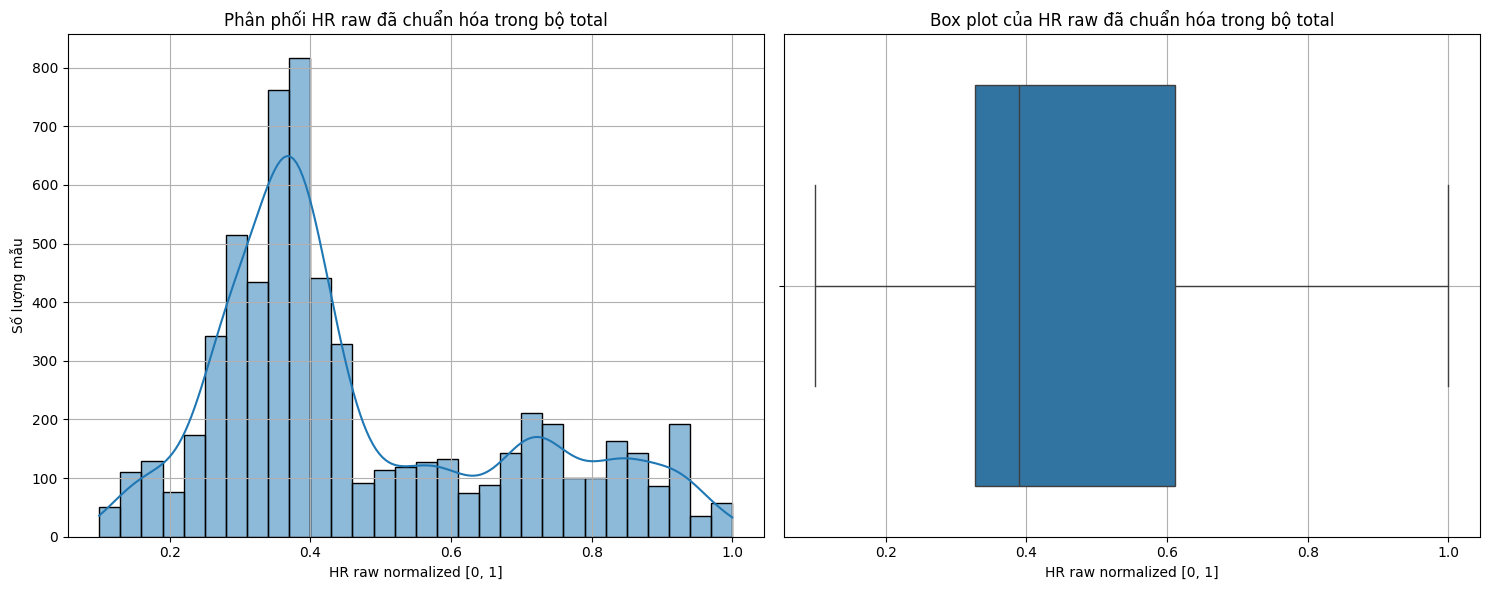

In [21]:
# Kiểm tra kết quả chuẩn hóa
print("\nThống kê HR raw total sau khi chuẩn hóa:")
print(f"Min: {np.min(hr_raw_total_normalized):.4f}, Max: {np.max(hr_raw_total_normalized):.4f}")
print(f"Mean: {np.mean(hr_raw_total_normalized):.4f}, Std: {np.std(hr_raw_total_normalized):.4f}")

# Vẽ phân phối HR raw sau khi chuẩn hóa
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.histplot(hr_raw_total_normalized, kde=True, bins=30)
plt.title('Phân phối HR raw đã chuẩn hóa trong bộ total')
plt.xlabel('HR raw normalized [0, 1]')
plt.ylabel('Số lượng mẫu')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(x=hr_raw_total_normalized)
plt.title('Box plot của HR raw đã chuẩn hóa trong bộ total')
plt.xlabel('HR raw normalized [0, 1]')
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
# Chia lại thành tập train và test từ dữ liệu total đã lọc và chuẩn hóa
from sklearn.model_selection import train_test_split

# Sử dụng tỷ lệ 80% train, 20% test
X_train_filtered, X_test_filtered, hr_raw_train_normalized, hr_raw_test_normalized = train_test_split(
    X_total_filtered, hr_raw_total_normalized, test_size=0.2, random_state=42
)

# Lấy giá trị HR raw gốc tương ứng cho việc hiển thị
train_indices = np.arange(len(X_total_filtered))
train_indices, test_indices = train_test_split(
    train_indices, test_size=0.2, random_state=42
)
hr_raw_train_filtered = hr_raw_total_filtered[train_indices]
hr_raw_test_filtered = hr_raw_total_filtered[test_indices]

Số mẫu train ban đầu: 5342
Số mẫu train sau khi lọc: 5083
Tỷ lệ giữ lại (train): 95.15%
Số mẫu test ban đầu: 1336
Số mẫu test sau khi lọc: 1271
Tỷ lệ giữ lại (test): 95.13%

Thống kê HR raw sau khi chia tập:
Train - Min: 0.0999, Max: 0.9992
Train - Mean: 0.4688, Std: 0.2121
Test - Min: 0.1027, Max: 0.9999
Test - Mean: 0.4683, Std: 0.2147


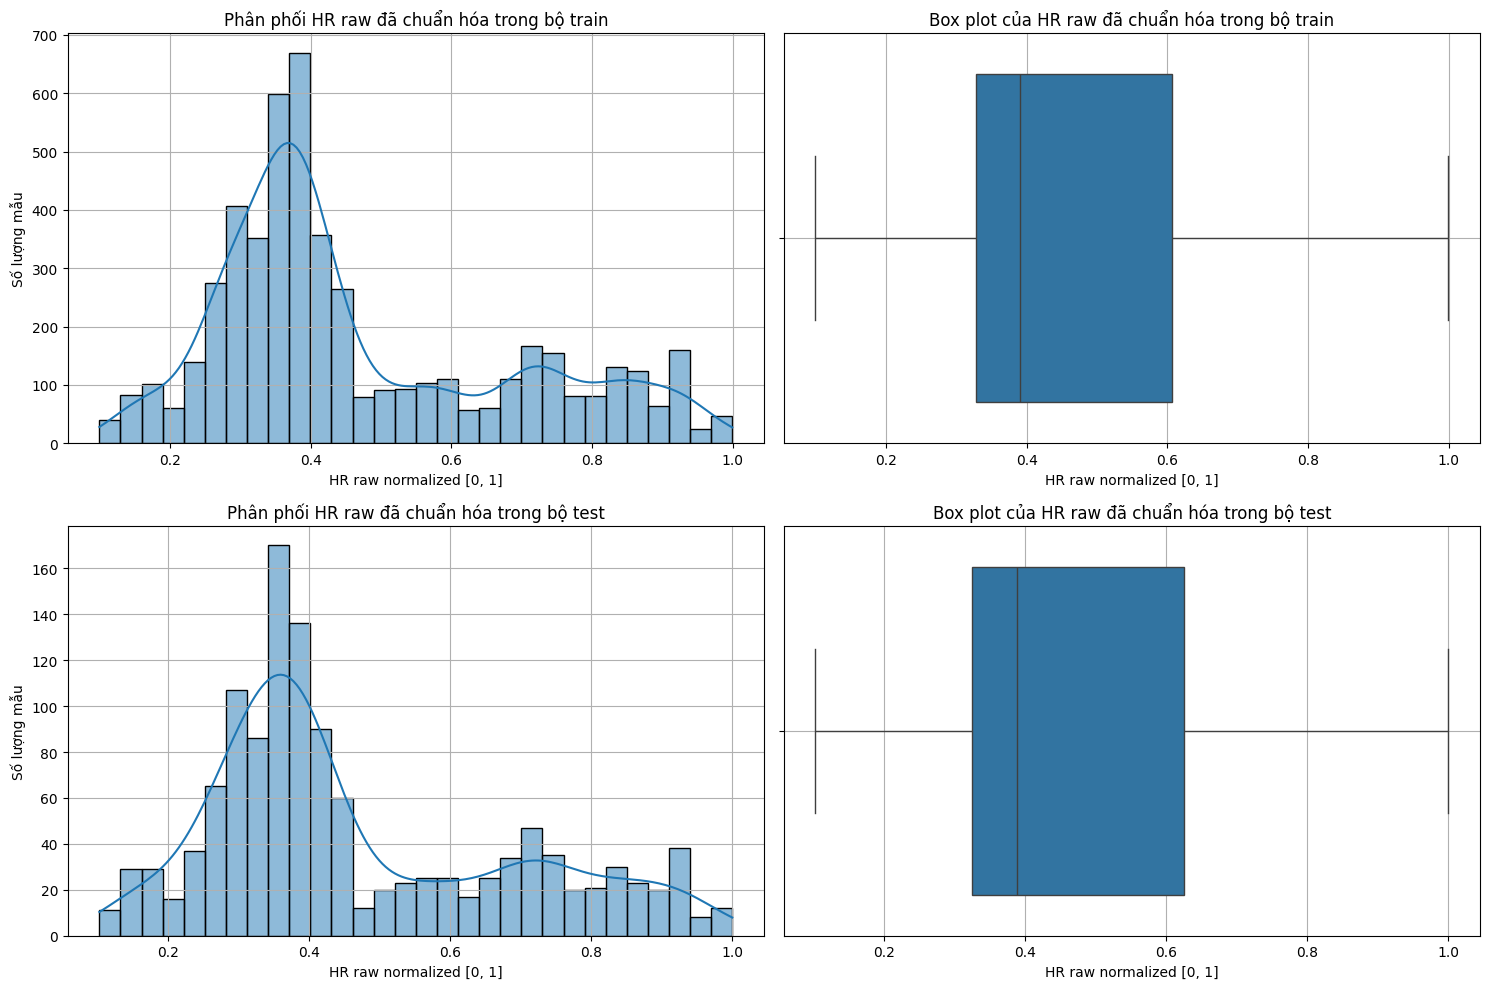

In [23]:
# In thông tin về số lượng mẫu đã lọc
print(f"Số mẫu train ban đầu: {X_train_loaded.shape[0]}")
print(f"Số mẫu train sau khi lọc: {X_train_filtered.shape[0]}")
print(f"Tỷ lệ giữ lại (train): {X_train_filtered.shape[0]/X_train_loaded.shape[0]*100:.2f}%")

print(f"Số mẫu test ban đầu: {X_test_loaded.shape[0]}")
print(f"Số mẫu test sau khi lọc: {X_test_filtered.shape[0]}")
print(f"Tỷ lệ giữ lại (test): {X_test_filtered.shape[0]/X_test_loaded.shape[0]*100:.2f}%")

# Kiểm tra thống kê HR raw sau khi chia tập
print("\nThống kê HR raw sau khi chia tập:")
print(f"Train - Min: {np.min(hr_raw_train_normalized):.4f}, Max: {np.max(hr_raw_train_normalized):.4f}")
print(f"Train - Mean: {np.mean(hr_raw_train_normalized):.4f}, Std: {np.std(hr_raw_train_normalized):.4f}")
print(f"Test - Min: {np.min(hr_raw_test_normalized):.4f}, Max: {np.max(hr_raw_test_normalized):.4f}")
print(f"Test - Mean: {np.mean(hr_raw_test_normalized):.4f}, Std: {np.std(hr_raw_test_normalized):.4f}")

# Vẽ phân phối HR raw sau khi chia tập
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(hr_raw_train_normalized, kde=True, bins=30)
plt.title('Phân phối HR raw đã chuẩn hóa trong bộ train')
plt.xlabel('HR raw normalized [0, 1]')
plt.ylabel('Số lượng mẫu')
plt.grid(True)

plt.subplot(2, 2, 2)
sns.boxplot(x=hr_raw_train_normalized)
plt.title('Box plot của HR raw đã chuẩn hóa trong bộ train')
plt.xlabel('HR raw normalized [0, 1]')
plt.grid(True)

plt.subplot(2, 2, 3)
sns.histplot(hr_raw_test_normalized, kde=True, bins=30)
plt.title('Phân phối HR raw đã chuẩn hóa trong bộ test')
plt.xlabel('HR raw normalized [0, 1]')
plt.ylabel('Số lượng mẫu')
plt.grid(True)

plt.subplot(2, 2, 4)
sns.boxplot(x=hr_raw_test_normalized)
plt.title('Box plot của HR raw đã chuẩn hóa trong bộ test')
plt.xlabel('HR raw normalized [0, 1]')
plt.grid(True)

plt.tight_layout()
plt.show()

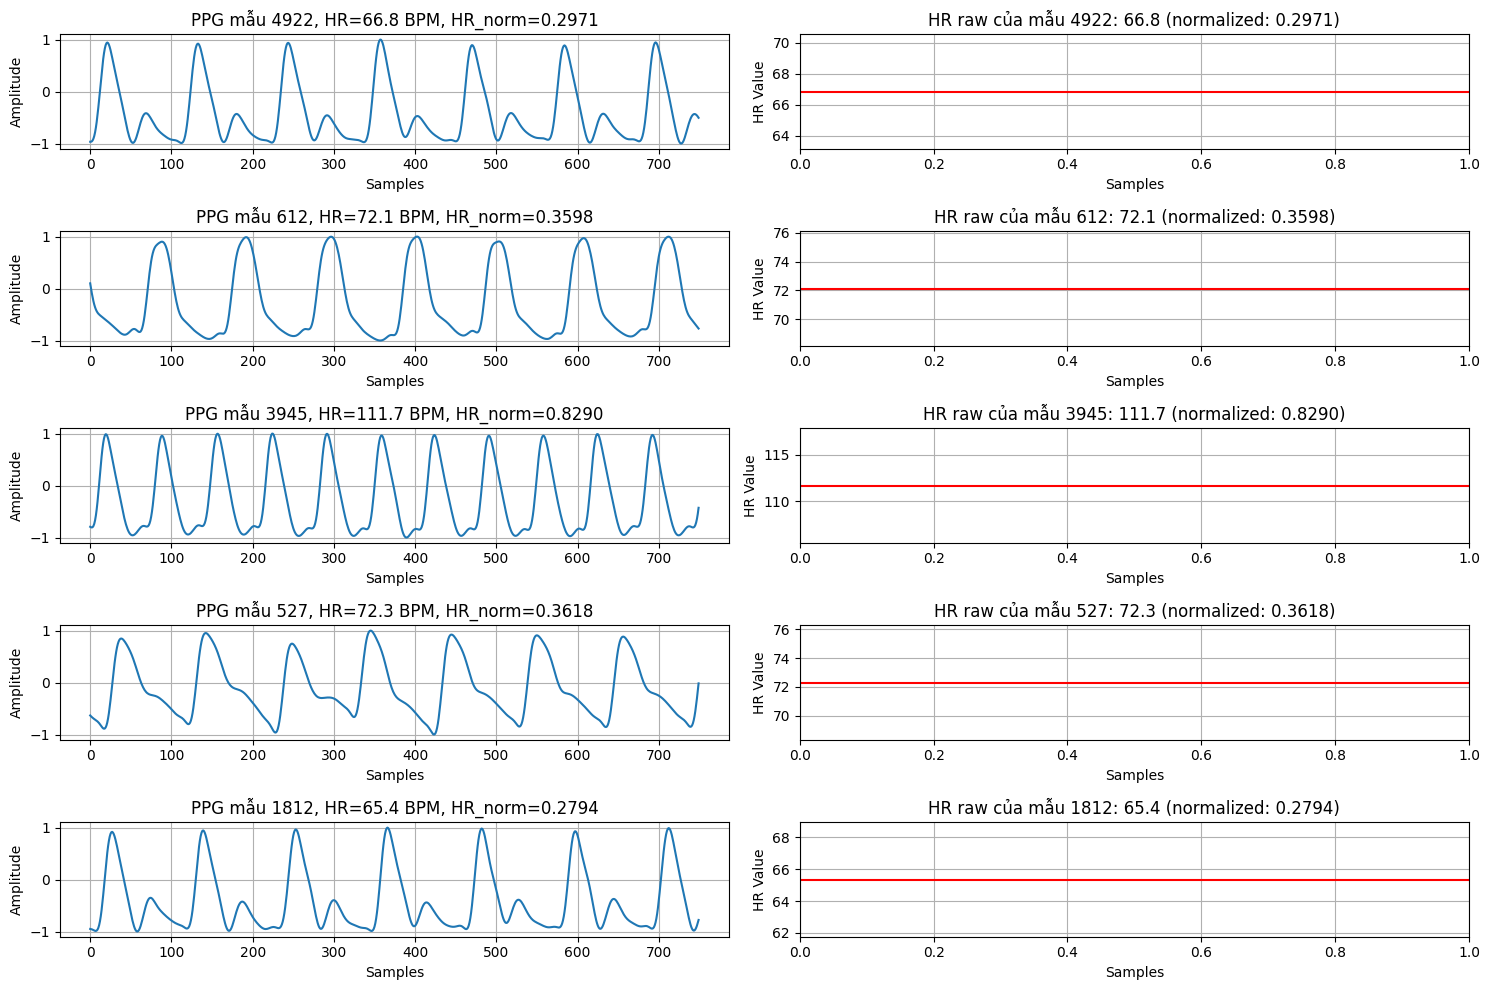

In [24]:
# Vẽ một vài mẫu để double check
plt.figure(figsize=(15, 10))
for i in range(5):
    idx = np.random.randint(0, X_train_filtered.shape[0])

    # Vẽ tín hiệu PPG
    plt.subplot(5, 2, i*2+1)
    plt.plot(X_train_filtered[idx])
    plt.title(f'PPG mẫu {idx}, HR={hr_raw_train_filtered[idx]:.1f} BPM, HR_norm={hr_raw_train_normalized[idx]:.4f}')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.grid(True)

    # Vẽ tín hiệu HR raw tương ứng
    plt.subplot(5, 2, i*2+2)
    plt.axhline(hr_raw_train_filtered[idx], color='r')
    plt.title(f'HR raw của mẫu {idx}: {hr_raw_train_filtered[idx]:.1f} (normalized: {hr_raw_train_normalized[idx]:.4f})')
    plt.xlabel('Samples')
    plt.ylabel('HR Value')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [25]:
# Thiết lập device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng device: {device}")

# Chuyển đổi dữ liệu đã lọc và chuẩn hóa thành tensor
X_train_tensor = torch.FloatTensor(X_train_filtered)
hr_raw_train_tensor = torch.FloatTensor(hr_raw_train_normalized.reshape(-1, 1))  # Reshape để có shape (n, 1)

X_test_tensor = torch.FloatTensor(X_test_filtered)
hr_raw_test_tensor = torch.FloatTensor(hr_raw_test_normalized.reshape(-1, 1))  # Reshape để có shape (n, 1)

# Tạo dataset và dataloader
train_dataset = TensorDataset(X_train_tensor, hr_raw_train_tensor)
test_dataset = TensorDataset(X_test_tensor, hr_raw_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Sử dụng device: cuda


In [26]:
# Lưu dữ liệu đã xử lý vào file .mat
import scipy.io as sio
data_to_save = {
    'X_train_filtered': X_train_filtered,
    'hr_raw_train_normalized': hr_raw_train_normalized,
    'X_test_filtered': X_test_filtered,
    'hr_raw_test_normalized': hr_raw_test_normalized
}
sio.savemat('final_capno_data.mat', data_to_save)
print("Đã lưu dữ liệu vào file final_capno_data.mat thành công!")

# Kiểm tra kích thước dữ liệu
print(f"X_train_filtered shape: {X_train_filtered.shape}")
print(f"hr_raw_train_normalized shape: {hr_raw_train_normalized.shape}")
print(f"X_test_filtered shape: {X_test_filtered.shape}")
print(f"hr_raw_test_normalized shape: {hr_raw_test_normalized.shape}")

# Kiểm tra kích thước dữ liệu trong dataloader
sample_data, sample_condition = next(iter(train_loader))
print(f"Batch data shape: {sample_data.shape}")
print(f"Batch condition shape: {sample_condition.shape}")

Đã lưu dữ liệu vào file final_capno_data.mat thành công!
X_train_filtered shape: (5083, 750)
hr_raw_train_normalized shape: (5083,)
X_test_filtered shape: (1271, 750)
hr_raw_test_normalized shape: (1271,)
Batch data shape: torch.Size([64, 750])
Batch condition shape: torch.Size([64, 1])


In [27]:
X_train_loaded = loaded_data['X_train_norm']
X_test_loaded = loaded_data['X_test_norm']
hr_raw_train_loaded = loaded_data['hr_raw_train'].flatten()
hr_raw_test_loaded = loaded_data['hr_raw_test'].flatten()
X_total_loaded = loaded_data['X_total_norm']
hr_raw_total_loaded = loaded_data['hr_raw_total'].flatten()

hr_raw_total_mean = np.mean(hr_raw_total_loaded)
hr_raw_total_std = np.std(hr_raw_total_loaded)
hr_raw_lower_bound = hr_raw_total_mean - 2 * hr_raw_total_std
hr_raw_upper_bound = hr_raw_total_mean + 2 * hr_raw_total_std

valid_mask_total = np.logical_and(
    hr_raw_total_loaded >= hr_raw_lower_bound,
    hr_raw_total_loaded <= hr_raw_upper_bound
)
X_total_filtered = X_total_loaded[valid_mask_total]
hr_raw_total_filtered = hr_raw_total_loaded[valid_mask_total]

def normalize_hr_raw(hr_raw_data, min_hr=hr_raw_lower_bound, max_hr=hr_raw_upper_bound):
    normalized = (hr_raw_data - min_hr) / (max_hr - min_hr)
    normalized = np.clip(normalized, 0, 1)
    return normalized

hr_raw_total_normalized = normalize_hr_raw(hr_raw_total_filtered)

from sklearn.model_selection import train_test_split
X_train_filtered, X_test_filtered, hr_raw_train_normalized, hr_raw_test_normalized = train_test_split(
    X_total_filtered, hr_raw_total_normalized, test_size=0.2, random_state=42
)
train_indices = np.arange(len(X_total_filtered))
train_indices, test_indices = train_test_split(
    train_indices, test_size=0.2, random_state=42
)
hr_raw_train_filtered = hr_raw_total_filtered[train_indices]
hr_raw_test_filtered = hr_raw_total_filtered[test_indices]

print(f"PPG min: {X_train_filtered.min()}, max: {X_train_filtered.max()}")
if X_train_filtered.max() <= 1.0 and X_train_filtered.min() >= 0.0:
    print("Chuẩn hóa PPG từ [0, 1] về [-1, 1]")
    X_train_filtered = X_train_filtered * 2 - 1
    X_test_filtered = X_test_filtered * 2 - 1

X_train_tensor = torch.FloatTensor(X_train_filtered)
hr_raw_train_tensor = torch.FloatTensor(hr_raw_train_normalized.reshape(-1, 1))
X_test_tensor = torch.FloatTensor(X_test_filtered)
hr_raw_test_tensor = torch.FloatTensor(hr_raw_test_normalized.reshape(-1, 1))

batch_size = 32  # Giảm từ 64
train_dataset = TensorDataset(X_train_tensor, hr_raw_train_tensor)
test_dataset = TensorDataset(X_test_tensor, hr_raw_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng device: {device}")

PPG min: -1.0, max: 1.0000000000000004
Sử dụng device: cuda


In [28]:
# Thiết lập tham số mô hình
input_size = X_train_filtered.shape[1]  # 750
noise_dim = 128

In [29]:
# Define Generator with Conv1D
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.input_layer = nn.Linear(noise_dim, 128 * 4)
        self.conv_layers = nn.Sequential(
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),  # [128, 4] -> [64, 8]
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),  # [64, 8] -> [32, 16]
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),  # [32, 16] -> [16, 32]
            nn.BatchNorm1d(16),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose1d(16, 1, kernel_size=39, stride=23, padding=1),  # [16, 32] -> [1, 750]
        )
        self.output_layer = nn.Tanh()

    def forward(self, z):
        x = self.input_layer(z)
        x = x.view(-1, 128, 4)
        x = self.conv_layers(x)
        x = self.output_layer(x)
        return x.squeeze(1)  # [batch_size, 750]

In [30]:
# Define Discriminator with Conv1D and Spectral Normalization
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv1d(1, 32, kernel_size=4, stride=2, padding=1)),  # [1, 750] -> [32, 375]
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=1)),  # [32, 375] -> [64, 187]
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Conv1d(64, 128, kernel_size=4, stride=2, padding=1)),  # [64, 187] -> [128, 93]
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool1d(93),  # Fix output length to 93
        )
        self.output_layer = nn.Linear(128 * 93, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.output_layer(x)
        return x  # Return logits, no sigmoid applied


In [31]:
# Build GAN
class GAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def forward(self, x):
        batch_size = x.size(0)
        z = torch.randn(batch_size, noise_dim).to(x.device)
        fake = self.generator(z)
        real_pred = self.discriminator(x)
        fake_pred = self.discriminator(fake)
        return fake, real_pred, fake_pred

    def generate(self, z=None, batch_size=1):
        if z is None:
            z = torch.randn(batch_size, noise_dim).to(device)
        return self.generator(z)


In [32]:
# Initialize model
generator = Generator(noise_dim, input_size)
discriminator = Discriminator(input_size)
gan = GAN(generator, discriminator)

# Move model to device
gan.to(device)

GAN(
  (generator): Generator(
    (input_layer): Linear(in_features=128, out_features=512, bias=True)
    (conv_layers): Sequential(
      (0): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): ConvTranspose1d(64, 32, kernel_size=(4,), stride=(2,), padding=(1,))
      (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): ConvTranspose1d(32, 16, kernel_size=(4,), stride=(2,), padding=(1,))
      (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2)
      (9): ConvTranspose1d(16, 1, kernel_size=(39,), stride=(23,), padding=(1,))
    )
    (output_layer): Tanh()
  )
  (discriminator): Discriminator(
    (conv_layers): Sequential(
      (0): Conv1d(1, 32, kernel_size=(4,), str

In [33]:
# Display model architecture
print("\n=== Generator Architecture ===")
print(generator)
print("\n=== Discriminator Architecture ===")
print(discriminator)
print("\n=== GAN Architecture ===")
print(gan)

# Count total parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal Generator parameters: {count_parameters(generator):,}")
print(f"Total Discriminator parameters: {count_parameters(discriminator):,}")
print(f"Total GAN parameters: {count_parameters(gan):,}")


=== Generator Architecture ===
Generator(
  (input_layer): Linear(in_features=128, out_features=512, bias=True)
  (conv_layers): Sequential(
    (0): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose1d(64, 32, kernel_size=(4,), stride=(2,), padding=(1,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): ConvTranspose1d(32, 16, kernel_size=(4,), stride=(2,), padding=(1,))
    (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): ConvTranspose1d(16, 1, kernel_size=(39,), stride=(23,), padding=(1,))
  )
  (output_layer): Tanh()
)

=== Discriminator Architecture ===
Discriminator(
  (conv_layers): Sequential(
    (0): Conv1d(1, 32, kernel_size=(4,), stride=(

In [34]:
# Visualize data flow through the model
def visualize_model_flow():
    print(f"\nInput shape: {sample_data[0:1].shape}")
    batch_size = sample_data[0:1].size(0)
    z = torch.randn(batch_size, noise_dim).to(device)
    print(f"Noise z shape: {z.shape}")

    # Set Generator to evaluation mode
    generator.eval()
    with torch.no_grad():
        fake = generator(z)
    print(f"Generated fake PPG shape: {fake.shape}")

    # Set Discriminator to evaluation mode
    discriminator.eval()
    with torch.no_grad():
        real_pred = discriminator(sample_data[0:1].to(device))
        print(f"Discriminator real prediction shape: {real_pred.shape}")
        fake_pred = discriminator(fake)
        print(f"Discriminator fake prediction shape: {fake_pred.shape}")

    # Restore training mode
    generator.train()
    discriminator.train()

# Call function to check
visualize_model_flow()


Input shape: torch.Size([1, 750])
Noise z shape: torch.Size([1, 128])
Generated fake PPG shape: torch.Size([1, 750])
Discriminator real prediction shape: torch.Size([1, 1])
Discriminator fake prediction shape: torch.Size([1, 1])


In [35]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast  # Thêm import autocast

In [36]:
# Define parameters
noise_dim = 128
input_size = 750
learning_rate = 0.00005
batch_size = 32
epochs = 600
beta1 = 0.5
lambda_gp = 2
n_critic = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cuda


In [37]:
# Initialize optimizers and schedulers
optimizer_G = optim.Adam(gan.generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_D = optim.Adam(gan.discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
scheduler_G = ReduceLROnPlateau(optimizer_G, mode='min', factor=0.5, patience=20)
scheduler_D = ReduceLROnPlateau(optimizer_D, mode='min', factor=0.5, patience=20)

criterion = nn.BCEWithLogitsLoss()

# Compute gradient penalty (every 10 batches)
def compute_gradient_penalty(discriminator, real_data, fake_data, device, batch_idx):
    if batch_idx % 10 != 0:
        return torch.tensor(0.0, device=device)
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1, device=device)
    alpha = alpha.expand(real_data.size())
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates = interpolates.requires_grad_(True)
    disc_interpolates = discriminator(interpolates)
    gradients = torch.autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(disc_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
    return gradient_penalty

# Training loop
g_losses = []
d_losses = []
best_g_loss = float('inf')
best_epoch = 0
patience = 30
patience_counter = 0

checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [38]:
for epoch in range(epochs):
    gan.train()
    total_g_loss = 0
    total_d_loss = 0

    # Dynamic label smoothing
    real_label_value = max(0.7, 0.9 - (epoch * 0.002))

    for batch_idx, (data, _) in enumerate(train_loader):  # Ignore condition
        data = data.to(device)
        batch_size = data.size(0)

        real_label = torch.full((batch_size, 1), real_label_value, device=device)
        fake_label = torch.zeros(batch_size, 1, device=device)

        # Train Discriminator
        for _ in range(n_critic):
            optimizer_D.zero_grad()
            real_pred = gan.discriminator(data)
            d_loss_real = criterion(real_pred, real_label)
            z = torch.randn(batch_size, noise_dim, device=device)
            fake = gan.generator(z)
            fake_pred = gan.discriminator(fake.detach())
            d_loss_fake = criterion(fake_pred, fake_label)
            gp = compute_gradient_penalty(gan.discriminator, data, fake.detach(), device, batch_idx)
            d_loss = (d_loss_real + d_loss_fake) / 2 + gp
            d_loss.backward()
            optimizer_D.step()

        total_d_loss += d_loss.item() * batch_size

        # Train Generator
        optimizer_G.zero_grad()
        fake_pred = gan.discriminator(fake)
        g_loss = criterion(fake_pred, real_label)
        g_loss.backward()
        optimizer_G.step()

        torch.nn.utils.clip_grad_norm_(gan.generator.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(gan.discriminator.parameters(), max_norm=1.0)

        total_g_loss += g_loss.item() * batch_size

    avg_g_loss = total_g_loss / len(train_loader.dataset)
    avg_d_loss = total_d_loss / len(train_loader.dataset)

    g_losses.append(avg_g_loss)
    d_losses.append(avg_d_loss)

    scheduler_G.step(avg_g_loss)
    scheduler_D.step(avg_d_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}")
        print(f"Generator Loss: {avg_g_loss:.4f}, Discriminator Loss: {avg_d_loss:.4f}")

    if epoch % 50 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'gan_checkpoint_epoch_{epoch}.pth')
        torch.save({
            'epoch': epoch,
            'generator_state_dict': gan.generator.state_dict(),
            'discriminator_state_dict': gan.discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
            'scheduler_G_state_dict': scheduler_G.state_dict(),
            'scheduler_D_state_dict': scheduler_D.state_dict(),
            'g_loss': avg_g_loss,
            'd_loss': avg_d_loss,
            'g_losses': g_losses,
            'd_losses': d_losses
        }, checkpoint_path)

    if avg_g_loss < best_g_loss:
        best_g_loss = avg_g_loss
        best_epoch = epoch
        best_model_path = 'best_gan_combined.pth'
        torch.save({
            'epoch': epoch,
            'generator_state_dict': gan.generator.state_dict(),
            'discriminator_state_dict': gan.discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict(),
            'g_loss': avg_g_loss,
            'd_loss': avg_d_loss
        }, best_model_path)
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience and epoch >= 300:
        print(f"Early stopping at epoch {epoch} due to no improvement after {patience} epochs")
        break

history = {
    'g_losses': g_losses,
    'd_losses': d_losses,
    'best_epoch': best_epoch
}
torch.save(history, 'training_history_gan_combined.pth')

print("Training completed!")

Epoch 0/600
Generator Loss: 1.8752, Discriminator Loss: 0.4639
Epoch 10/600
Generator Loss: 2.8976, Discriminator Loss: 0.2343
Epoch 20/600
Generator Loss: 1.7440, Discriminator Loss: 0.3638
Epoch 30/600
Generator Loss: 1.0679, Discriminator Loss: 0.5536
Epoch 40/600
Generator Loss: 0.9637, Discriminator Loss: 0.6069
Epoch 50/600
Generator Loss: 0.8938, Discriminator Loss: 0.6511
Epoch 60/600
Generator Loss: 0.8942, Discriminator Loss: 0.6426
Epoch 70/600
Generator Loss: 0.8901, Discriminator Loss: 0.6437
Epoch 80/600
Generator Loss: 0.8869, Discriminator Loss: 0.6434
Epoch 90/600
Generator Loss: 0.8894, Discriminator Loss: 0.6393
Epoch 100/600
Generator Loss: 0.8866, Discriminator Loss: 0.6369
Epoch 110/600
Generator Loss: 0.8829, Discriminator Loss: 0.6381
Epoch 120/600
Generator Loss: 0.8828, Discriminator Loss: 0.6405
Epoch 130/600
Generator Loss: 0.8776, Discriminator Loss: 0.6431
Epoch 140/600
Generator Loss: 0.8764, Discriminator Loss: 0.6450
Epoch 150/600
Generator Loss: 0.8743

# **Đánh giá mô hình**

In [39]:
# Function to generate PPG samples
def evaluate_generation(gan, batch_size=1):
    gan.eval()
    with torch.no_grad():
        generated = gan.generate(batch_size=batch_size)
    return generated

Generator output shape: torch.Size([1, 750])


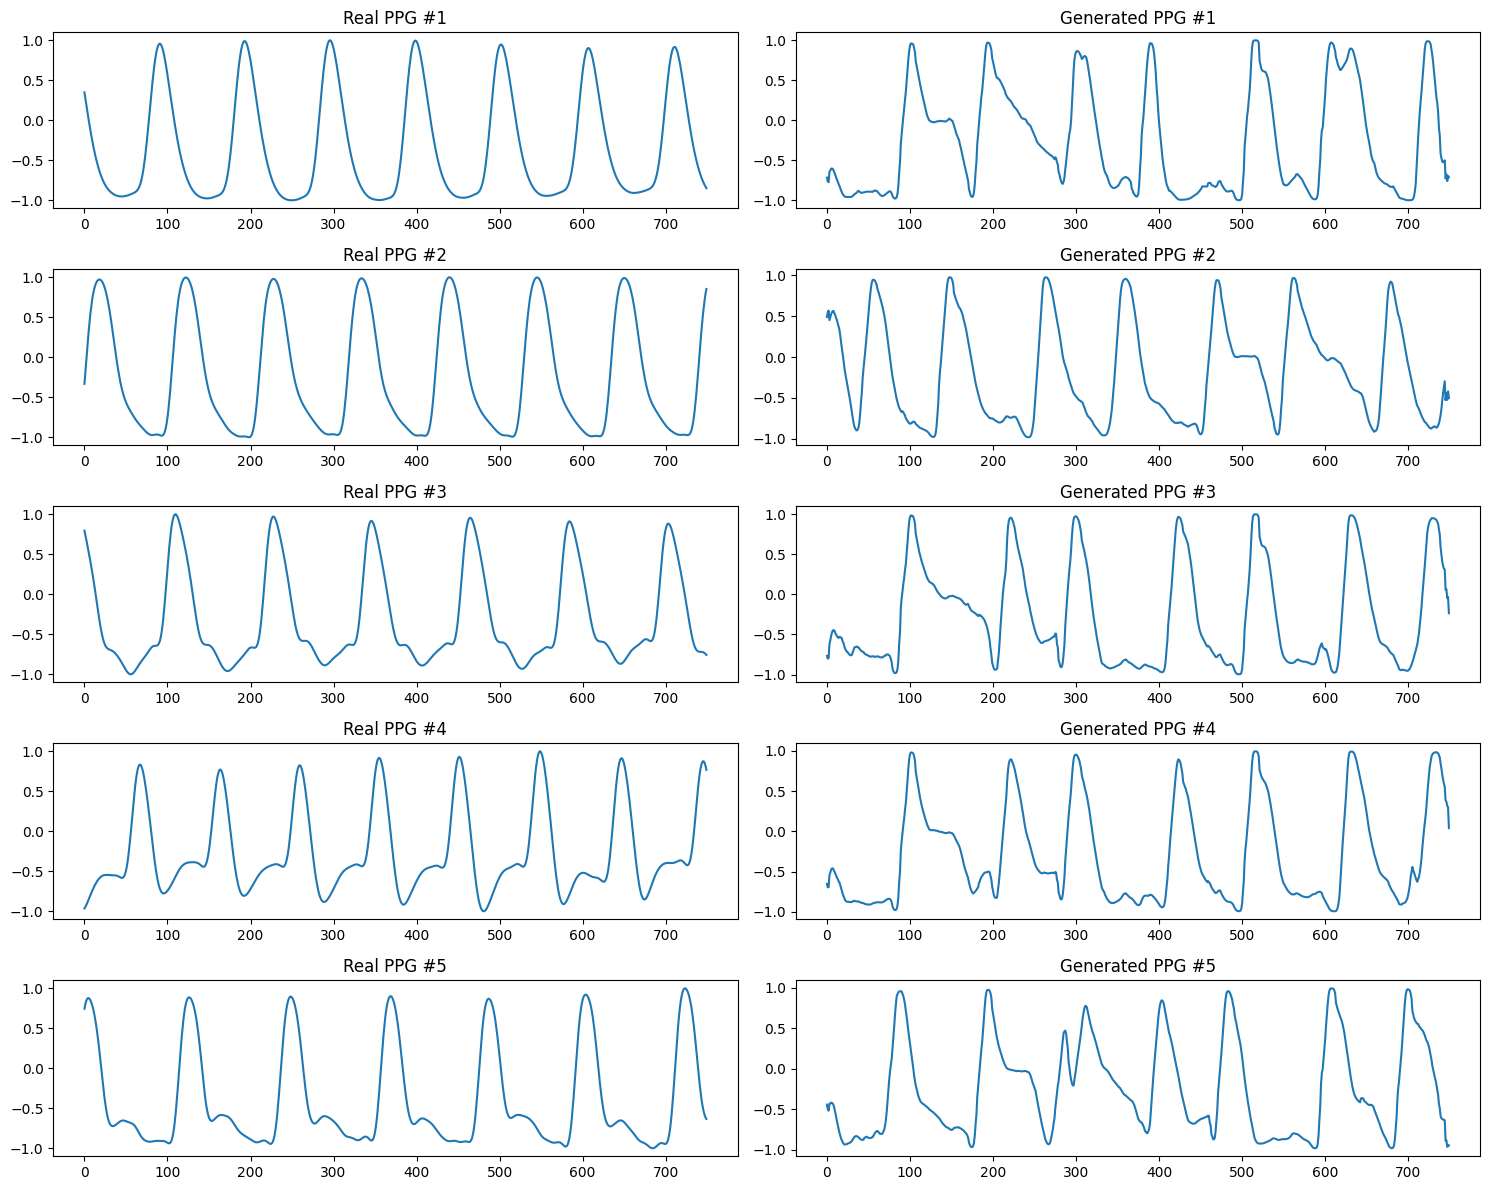

In [40]:
# Check Generator output shape
print(f"Generator output shape: {gan.generator(torch.randn(1, noise_dim).to(device)).shape}")

# Collect samples from test dataset
n_samples = 5
test_samples = []

for i, (data, _) in enumerate(test_loader):  # Ignore condition
    if i >= n_samples:
        break
    test_samples.append(data[0])

# Generate PPG samples
generated_samples = []
for _ in range(n_samples):
    generated = evaluate_generation(gan, batch_size=1)
    generated_samples.append(generated.cpu().squeeze(0))

# Plot real vs. generated PPG signals
plt.figure(figsize=(15, 12))

for i in range(n_samples):
    plt.subplot(n_samples, 2, 2*i+1)
    plt.plot(test_samples[i].cpu().numpy())
    plt.title(f'Real PPG #{i+1}')
    plt.subplot(n_samples, 2, 2*i+2)
    plt.plot(generated_samples[i].numpy())
    plt.title(f'Generated PPG #{i+1}')

plt.tight_layout()
plt.show()


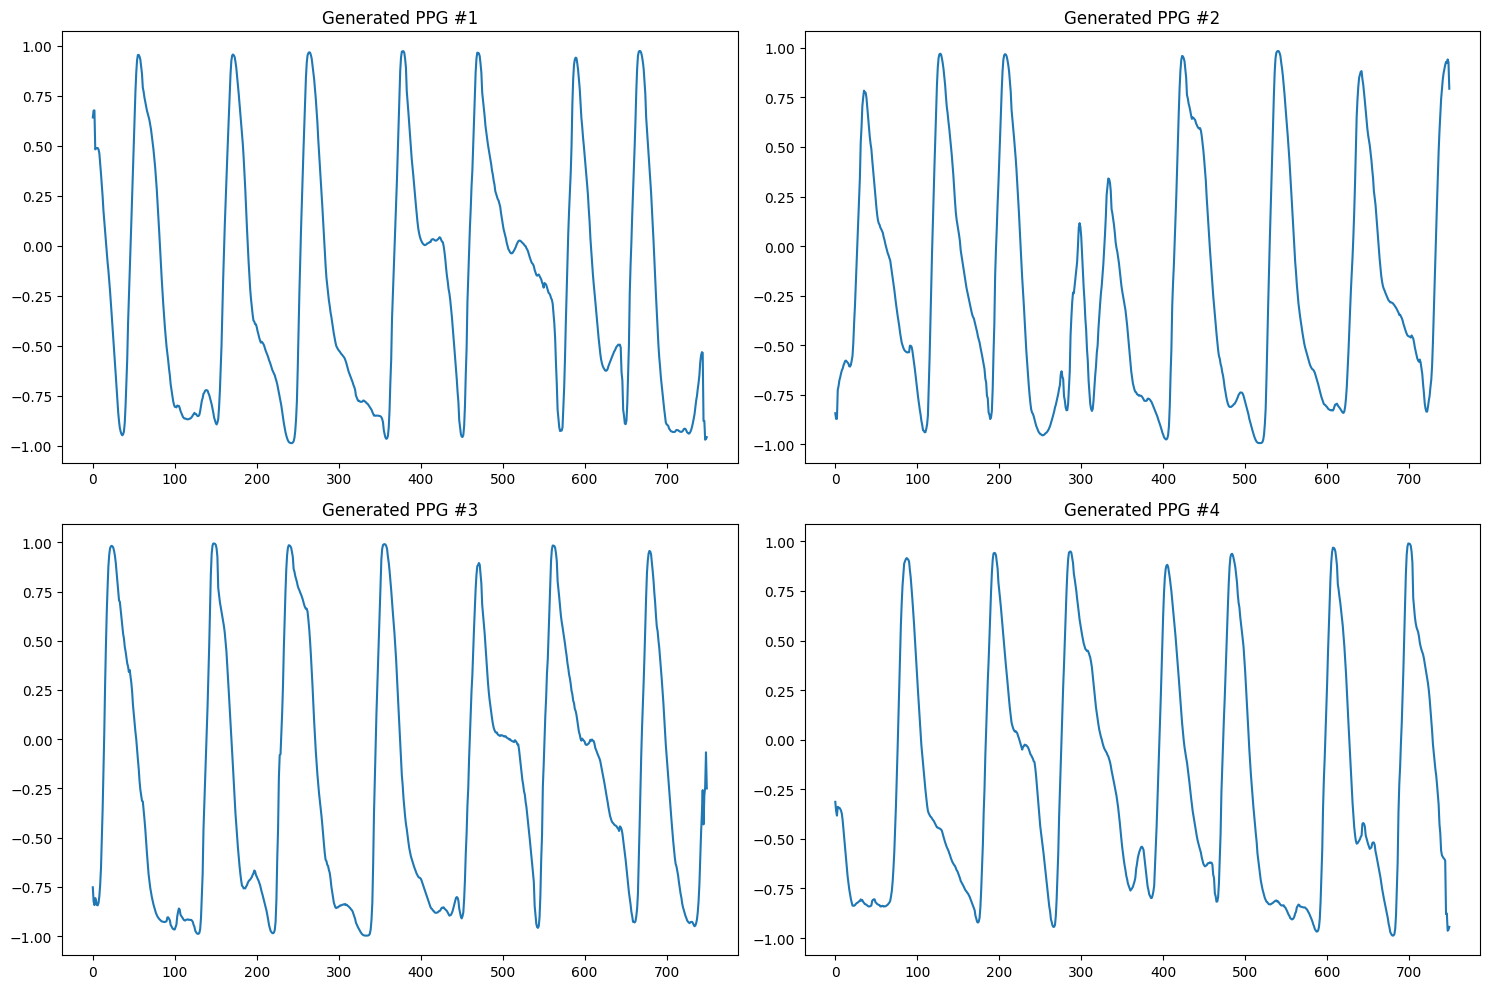

In [41]:
# Generate and visualize multiple PPG samples
n_generated = 4
generated_samples = evaluate_generation(gan, batch_size=n_generated)

# Plot generated PPG samples
plt.figure(figsize=(15, 10))

for i in range(n_generated):
    plt.subplot(2, 2, i+1)
    plt.plot(generated_samples[i].cpu().numpy())
    plt.title(f'Generated PPG #{i+1}')

plt.tight_layout()
plt.show()

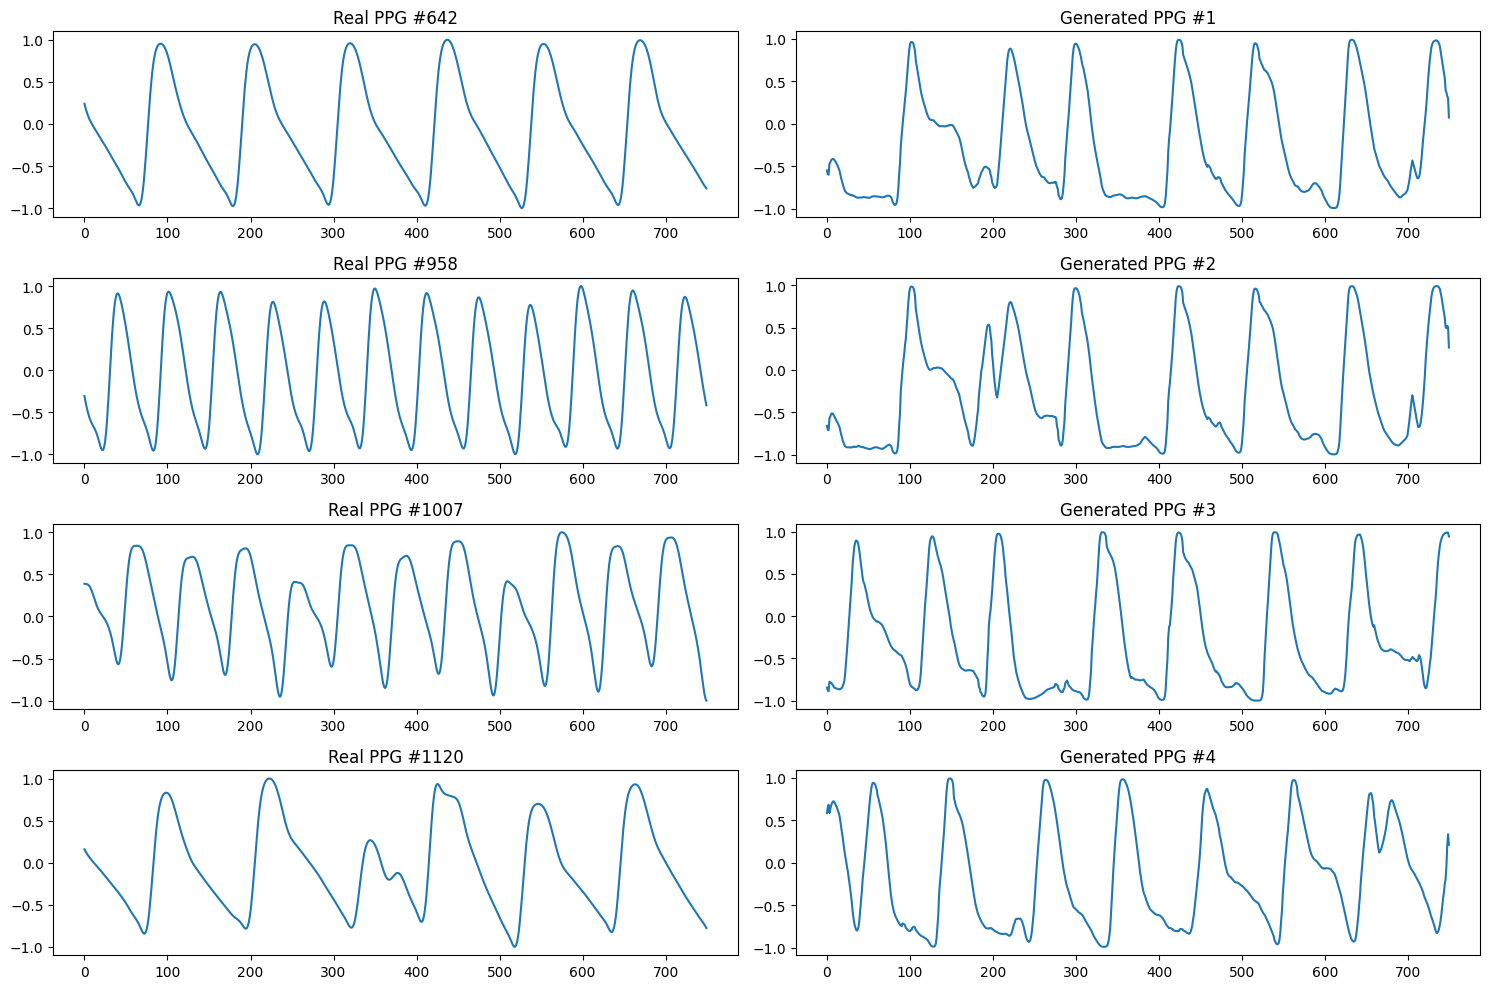

In [42]:
# Compare multiple real and generated PPG samples
plt.figure(figsize=(15, 10))

# Select 4 samples from test dataset
selection_indices = np.random.choice(range(len(test_dataset)), 4, replace=False)
selected_samples = [test_dataset[i][0] for i in selection_indices]

# Generate 4 PPG samples
generated_selected = evaluate_generation(gan, batch_size=4)

# Plot comparison
for i in range(len(selected_samples)):
    plt.subplot(4, 2, 2*i+1)
    plt.plot(selected_samples[i].cpu().numpy())
    plt.title(f'Real PPG #{selection_indices[i]}')

    plt.subplot(4, 2, 2*i+2)
    plt.plot(generated_selected[i].cpu().numpy())
    plt.title(f'Generated PPG #{i+1}')

plt.tight_layout()
plt.show()